# Objetivo do Projeto

- Desenvolver um modelo de Classificação capaz de prever se um cliente vai entrar em churn ou não.

- Etapas do Projeto:
    - Coleta de Dados
    - Análise Descritiva dos Dados
    - Análise Exploratória de Dados
    - Limpeza de Dados
    - Feature Engineering
    - Modelagem de Dados
    - Treinamento de Modelos
    - Avaliação de Modelos
    - Registro MLFLOW
    - Calcular ROI do Projeto
    - Construção de uma API

| Coluna             | Descrição                                                                 |
|--------------------|---------------------------------------------------------------------------|
| `RowNumber`        | Número da linha (apenas um índice)                                        |
| `CustomerId`       | ID único do cliente                                                       |
| `Surname`          | Sobrenome do cliente                                                      |
| `CreditScore`      | Pontuação de crédito (quanto maior, melhor o perfil de crédito)           |
| `Geography`        | País de origem do cliente (`France`, `Spain`, `Germany`)                  |
| `Gender`           | Gênero (`Male`/`Female`)                                                  |
| `Age`              | Idade do cliente                                                          |
| `Tenure`           | Quantos anos o cliente está no banco                                      |
| `Balance`          | Saldo da conta bancária                                                   |
| `NumOfProducts`    | Número de produtos adquiridos (cartões, investimentos, etc.)              |
| `HasCrCard`        | Possui cartão de crédito? (`1` = sim, `0` = não)                          |
| `IsActiveMember`   | É um cliente ativo? (`1` = sim, `0` = não)                                |
| `EstimatedSalary`  | Salário estimado                                                          |
| `Exited`           | **Target** — Saiu do banco? (`1` = sim, `0` = não)                        |


# Imports

In [1]:
import numpy as np
import pandas as pd
import mlflow

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
from src.utils.utils import ChurnModelUtils

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [5]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

In [6]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment(experiment_id=207252348785056863)

<Experiment: artifact_location='mlflow-artifacts:/207252348785056863', creation_time=1752069687363, experiment_id='207252348785056863', last_update_time=1752069687363, lifecycle_stage='active', name='churn-model', tags={}>

In [7]:
ciclo = 'Ciclo2'

# Helper Functions

In [8]:



def plot_confusion_matrix(y_true, y_pred, model_name="Modelo"):
    """
    Plota a matriz de confusão para um modelo de classificação.

    Args:
        y_true: Valores reais (array ou Series)
        y_pred: Valores previstos pelo modelo (array ou Series)
        model_name: Nome do modelo (string)
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.show()

# Data Load

In [9]:
df = pd.read_csv('../data/rclientes.csv')

# Descrição dos Dados

In [10]:
df1 = df.copy()

## 1.1 Dimensão dos Dados

In [11]:
print('Quantidade de Linhas: {}'.format(df1.shape[0]))
print('Quantidade de Colunas: {}'.format(df1.shape[1]))

Quantidade de Linhas: 10000
Quantidade de Colunas: 14


## 1.2 Tipo dos Dados

In [12]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 1.3 Check Na

In [13]:
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 1.4 Estatística Descritiva

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,RowNumber,1.00,10000.00,9999.00,5000.50,5000.50,2886.75,0.00,-1.20
1,CustomerId,15565701.00,15815690.00,249989.00,15690940.57,15690738.00,71932.59,0.00,-1.20
2,CreditScore,350.00,850.00,500.00,650.53,652.00,96.65,-0.07,-0.43
3,Age,18.00,92.00,74.00,38.92,37.00,10.49,1.01,1.40
4,Tenure,0.00,10.00,10.00,5.01,5.00,2.89,0.01,-1.17
5,Balance,0.00,250898.09,250898.09,76485.89,97198.54,62394.29,-0.14,-1.49
6,NumOfProducts,1.00,4.00,3.00,1.53,1.00,0.58,0.75,0.58
7,HasCrCard,0.00,1.00,1.00,0.71,1.00,0.46,-0.90,-1.19
8,IsActiveMember,0.00,1.00,1.00,0.52,1.00,0.50,-0.06,-2.00
9,EstimatedSalary,11.58,199992.48,199980.90,100090.24,100193.91,57507.62,0.00,-1.18


In [16]:
df1['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

# 3.0 Análise Exploratória de Dados

In [17]:
df2 = df1.copy()

In [18]:
df3 = df2.copy()

## 3.1 Análise Univariada

In [19]:
df3.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


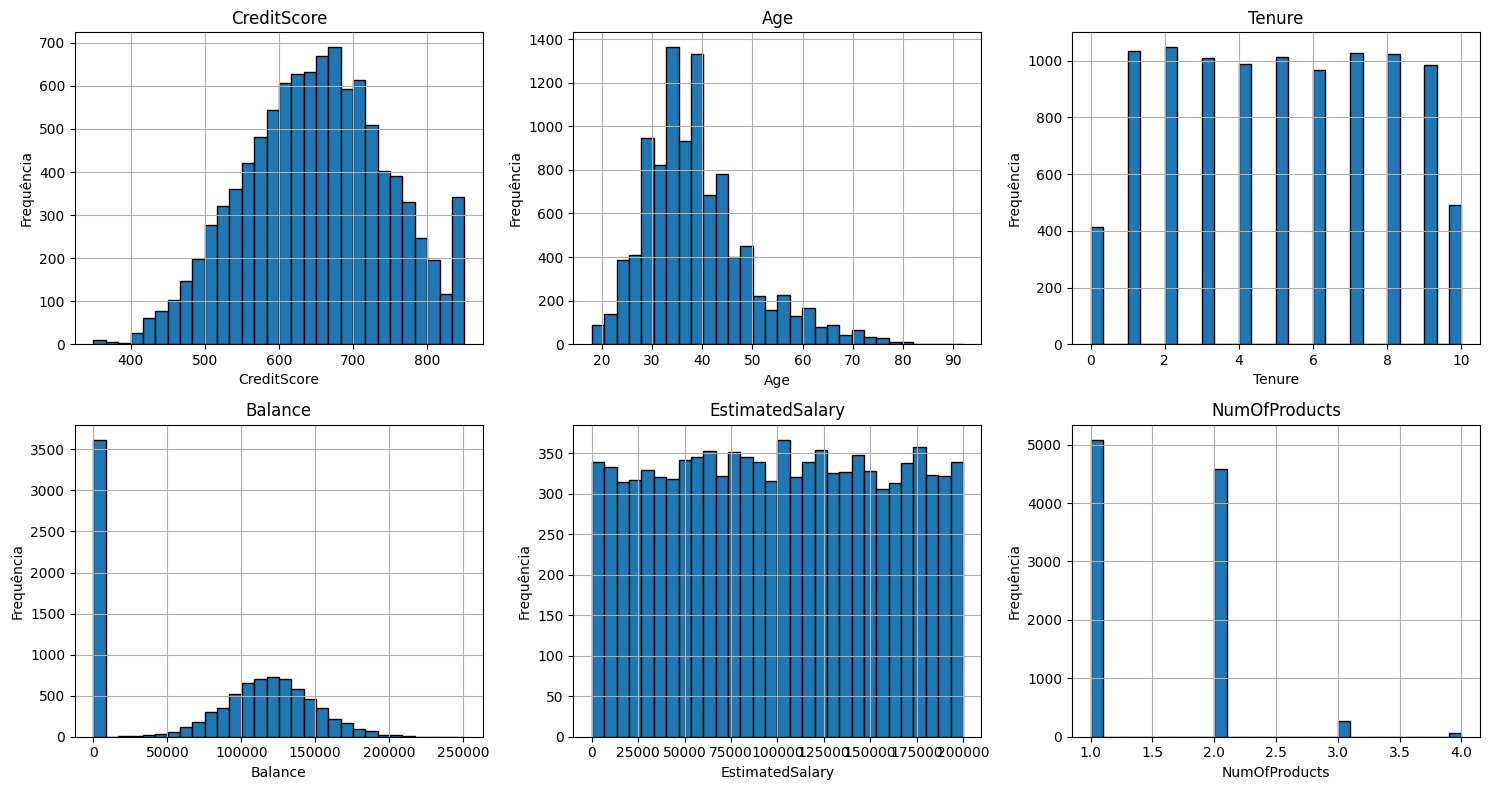

In [20]:
numerics_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']

def plot_numeric_histograms(df, numeric_features, bins=30):
    n = len(numeric_features)
    ncols = min(n, 3)  # até 3 colunas por linha
    nrows = (n + ncols - 1) // ncols

    plt.figure(figsize=(5 * ncols, 4 * nrows))
    for i, col in enumerate(numeric_features):
        plt.subplot(nrows, ncols, i + 1)
        df[col].hist(bins=bins, edgecolor='black')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()

plot_numeric_histograms(df3, numerics_features)

In [21]:
def plot_bar_categorical(df, categorical_features):
    n = len(categorical_features)
    plt.figure(figsize=(5 * n, 4))
    for i, col in enumerate(categorical_features):
        plt.subplot(1, n, i + 1)
        df[col].value_counts().sort_index().plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
        plt.title(col)
        plt.xlabel('Categoria')
        plt.ylabel('Contagem')
        plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

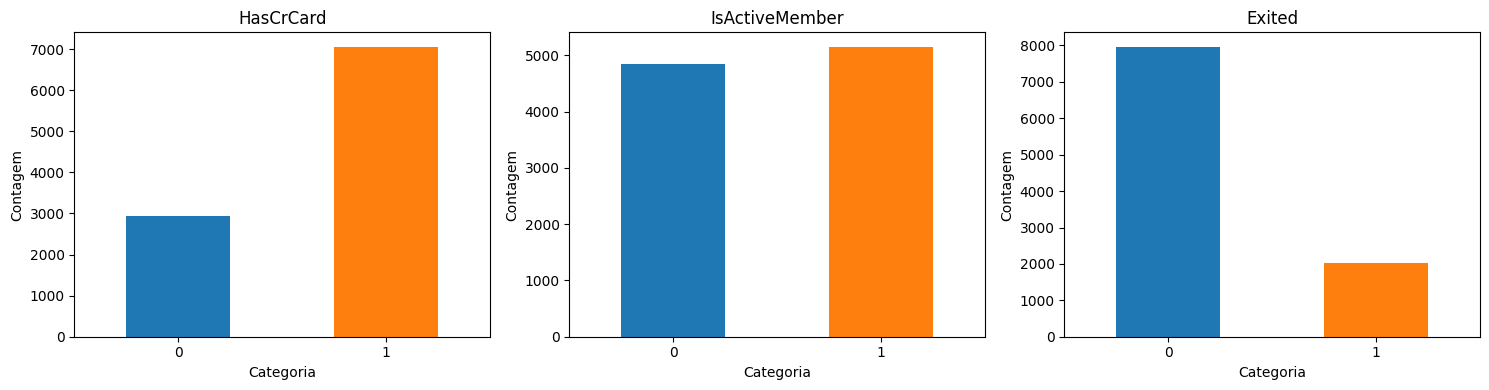

In [22]:
categorical_features = ['HasCrCard', 'IsActiveMember', 'Exited']
plot_bar_categorical(df3, categorical_features)

## 3.2 Análise Bivariada

- Lista de Hipíteses

    - Pessoas mais novas tendem a encerrar seu relacionamento com a empresa
    - Pessoas com maior saldo na conta tendem a permanecer na empresa
    - Pessoas com CreditScore mais alto tendem a permanecer na empresa
    - Pessoas com mais produtos tendem a permanecer na empresa
    - Pessoas com maior salario tendem a permanecer na empresa
    - Pessoas com mais tempo de relacionamento com a empresa tendem a permanecer na empresa
    - Pessoas que possuem cartao de crédito tendem a permanecer na empresa
    - Mulheres tendem mais a permanecer na empresa do que homens
    - Taxa de Churn entre os diferentes países

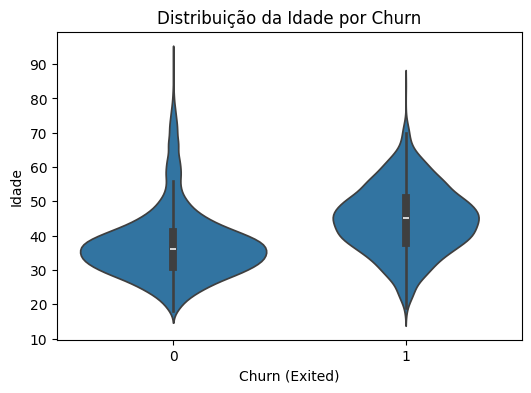

In [23]:
# Pessoas mais novas tendem a encerrar seu relacionamento com a empresa

# 1. Idade vs Churn (violino)
plt.figure(figsize=(6,4))
sns.violinplot(x='Exited', y='Age', data=df3)
plt.title('Distribuição da Idade por Churn')
plt.xlabel('Churn (Exited)')
plt.ylabel('Idade')
plt.show()

**Insight**: Clientes mais velhos apresentam uma taxa de churn maior.

**Interpretação**: Clientes de maior idade podem estar menos satisfeitos com serviços digitais, podem buscar bancos mais tradicionais ou podem estar em fase de vida com menor necessidade de produtos bancários.

**Ação**: Desenvolver produtos e comunicações específicas para o público sênior, focando em simplicidade, atendimento personalizado e benefícios para essa faixa etária.

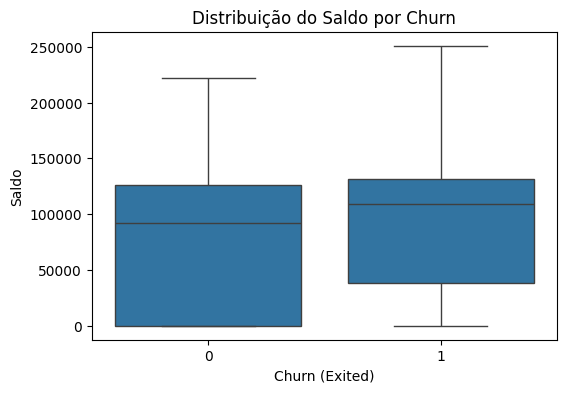

In [24]:
# 2. Saldo vs Churn (boxplot)
plt.figure(figsize=(6,4))
sns.boxplot(x='Exited', y='Balance', data=df3)
plt.title('Distribuição do Saldo por Churn')
plt.xlabel('Churn (Exited)')
plt.ylabel('Saldo')
plt.show()

**Insight**: Clientes com saldo mais alto tendem a apresentar taxas de churn maiores.

**Interpretação**: Clientes com mais dinheiro no banco são mais visados por concorrentes e podem receber propostas mais atrativas. Também podem ser mais exigentes em relação a taxas e serviços.

**Ação**: Implementar programas de fidelidade, atendimento VIP e ofertas exclusivas para clientes de alto saldo, visando retenção.

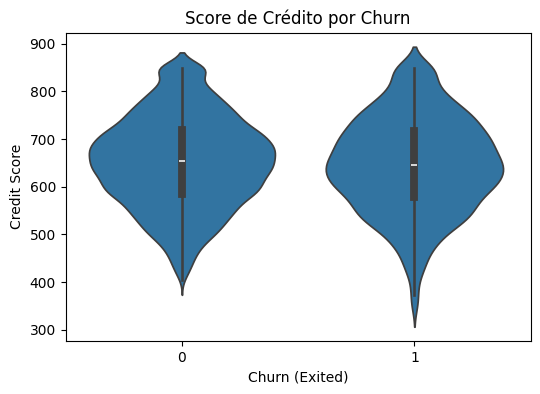

In [25]:
# 3. Score de Crédito vs Churn (violino)
plt.figure(figsize=(6,4))
sns.violinplot(x='Exited', y='CreditScore', data=df3)
plt.title('Score de Crédito por Churn')
plt.xlabel('Churn (Exited)')
plt.ylabel('Credit Score')
plt.show()

**Insight**: Clientes com score de crédito mais baixo têm uma leve tendência a churn, mas a diferença pode não ser tão expressiva.

**Interpretação**: Clientes com score baixo podem ter dificuldades em acessar produtos de crédito, o que pode gerar insatisfação.

**Ação**: Oferecer produtos personalizados para clientes com score baixo, como educação financeira e produtos de crédito com limites progressivos.

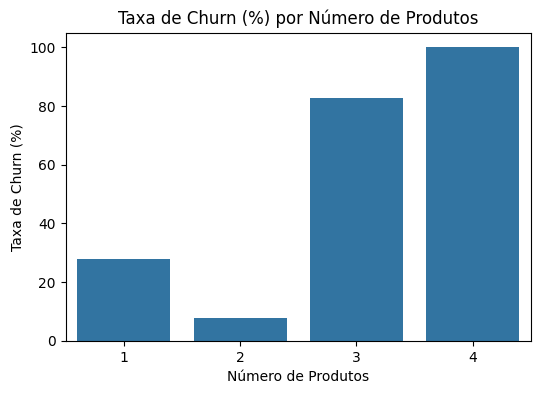

In [26]:
# 4. Número de Produtos vs Churn (barras)
churn_prod = df3.groupby('NumOfProducts')['Exited'].mean() * 100
plt.figure(figsize=(6,4))
sns.barplot(x=churn_prod.index, y=churn_prod.values)
plt.title('Taxa de Churn (%) por Número de Produtos')
plt.xlabel('Número de Produtos')
plt.ylabel('Taxa de Churn (%)')
plt.ylim(0, churn_prod.max() + 5)
plt.show()

In [27]:
clientes_por_produto = df3['NumOfProducts'].value_counts().sort_index()

# Calcula churn rate por número de produtos
churn_rate = df3.groupby('NumOfProducts')['Exited'].mean().sort_index() * 100

# Junta em um único DataFrame
tabela = pd.DataFrame({
    'NumOfProducts': clientes_por_produto.index,
    'Nº de Clientes': clientes_por_produto.values,
    'Churn Rate (%)': churn_rate.values
})

# Formata a tabela
tabela['Nº de Clientes'] = tabela['Nº de Clientes'].apply(lambda x: f"{x:,.0f}".replace(",", "."))
tabela['Churn Rate (%)'] = tabela['Churn Rate (%)'].apply(lambda x: f"{x:.2f}%")
tabela

,NumOfProducts,Nº de Clientes,Churn Rate (%)
0,1,5.084,27.71%
1,2,4.590,7.58%
2,3,266,82.71%
3,4,60,100.00%


**Insight**:

    Grupo com 1 e 2 produtos representa a grande maioria dos nossos clientes (96% da nossa base)

        - Grupo com 1 Produto (**27.7% de churn**): **CHURN RAZOÁVEL**
        - Grupo com 2 Produtos (**7.6% de Churn**): **CHURN MUITO BAIXO**
    
    Grupo com 3 ou 4 Produtos representa um percentual muito baixo da nossa base de clientes. E portanto o Churn Rate fica muito sensível.


**Ações**:

    - Incentivar a base com 1 produto a migrar para 2 produtos

        - Clientes com 2 produtos têm o menor churn (7.58%), enquanto os com 1 produto têm quase 4x mais risco de sair (27.71%).
    
    - Analisar criticamente os clientes com 3 e 4 produtos

        - Fazer uma investigação qualitativa (pesquisa, entrevistas ou análise de chamados)

            - Por que esses clientes saíram?

            - Existe algum produto que causa frustração quando combinado com outros?

            - O onboarding foi confuso? Algum produto tem baixa usabilidade?

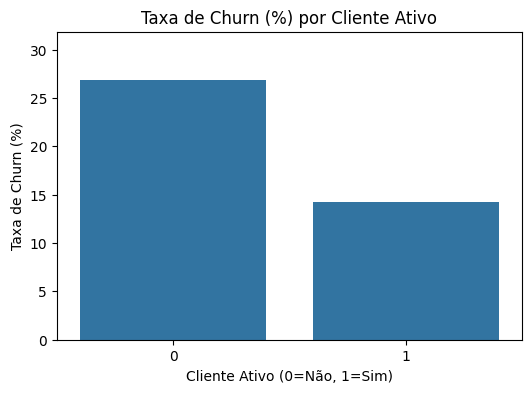

In [28]:
# 5. Atividade do Cliente vs Churn (barras)
churn_active = df3.groupby('IsActiveMember')['Exited'].mean() * 100
plt.figure(figsize=(6,4))
sns.barplot(x=churn_active.index.astype(str), y=churn_active.values)
plt.title('Taxa de Churn (%) por Cliente Ativo')
plt.xlabel('Cliente Ativo (0=Não, 1=Sim)')
plt.ylabel('Taxa de Churn (%)')
plt.ylim(0, churn_active.max() + 5)
plt.show()

**Insight**: 
    
    - Clientes inativos têm uma taxa de churn muito maior do que clientes ativos.

**Interpretação**: 

    - A falta de engajamento é um forte preditor de saída. Clientes que não usam os serviços do banco tendem a sair.

**Ação**: 

    - Monitorar sinais de inatividade e criar campanhas de reengajamento, como ofertas, notificações e contato proativo.

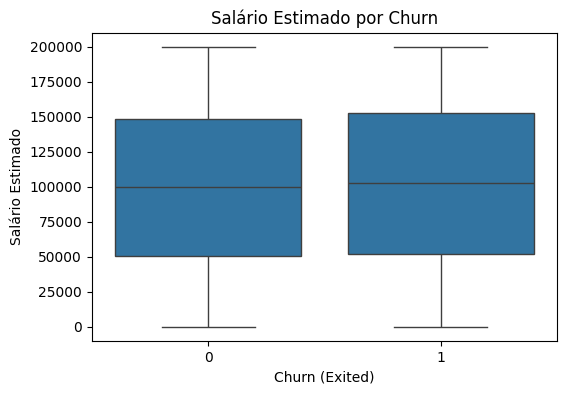

In [29]:
# 6. Salário Estimado vs Churn (boxplot)
plt.figure(figsize=(6,4))
sns.boxplot(x='Exited', y='EstimatedSalary', data=df3)
plt.title('Salário Estimado por Churn')
plt.xlabel('Churn (Exited)')
plt.ylabel('Salário Estimado')
plt.show()

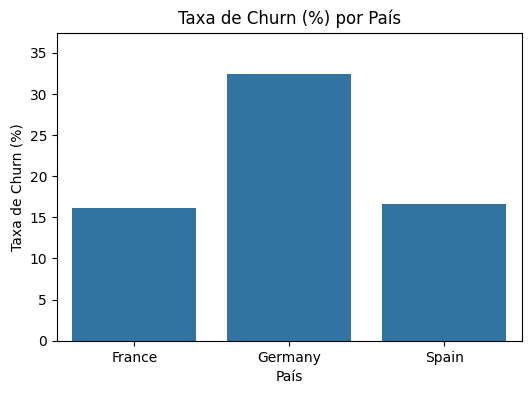

In [30]:

# 7. País vs Churn (barras) - se ainda tiver a coluna Geography
if 'Geography' in df3.columns:
    churn_geo = df3.groupby('Geography')['Exited'].mean() * 100
    plt.figure(figsize=(6,4))
    sns.barplot(x=churn_geo.index, y=churn_geo.values)
    plt.title('Taxa de Churn (%) por País')
    plt.xlabel('País')
    plt.ylabel('Taxa de Churn (%)')
    plt.ylim(0, churn_geo.max() + 5)
    plt.show()

**Insight**: A taxa de churn varia significativamente por país, com destaque para a Alemanha, que costuma apresentar churn mais alto.

**Interpretação**: Diferenças culturais, concorrência local e adequação dos produtos podem explicar essa variação.

**Ação**: Realizar análises específicas por país e adaptar produtos, comunicação e atendimento conforme o perfil de cada região.

## 3.3 Análise Multivariada

# 4.0 Feature Engineering

In [31]:
df4 = df3.copy()

In [32]:
df4

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [33]:

# 1. Engajamento
df4['is_inactive'] = (df4['IsActiveMember'] == 0).astype(int)

# 2. Cross-sell (tem mais de um produto)
df4['has_multiple_products'] = (df4['NumOfProducts'] > 1).astype(int)

# 3. Faixas de idade
df4['age_group'] = pd.cut(df4['Age'], bins=[17, 30, 40, 50, 60, 100], labels=['18-30','31-40','41-50','51-60','60+'])

# 4. Faixas de saldo
df4['balance_group'] = pd.cut(df4['Balance'], bins=[-0.01, 0, 50000, 100000, 200000, np.inf], labels=['Zerado','Baixo','Médio','Alto','Muito Alto'])

# 5. Interações
# df4['age_x_products'] = df4['Age'] * df4['NumOfProducts']
df4['active_x_products'] = df4['IsActiveMember'] * df4['NumOfProducts']

# 6. País (dummies e Alemanha)
df4 = pd.get_dummies(df4, columns=['Geography'], prefix='geo', drop_first=True)
df4['is_germany'] = (df4.get('geo_Germany', 0) == 1).astype(int)  # se existir coluna geo_Germany

# 7. Faixas de tempo de relacionamento
df4['tenure_group'] = pd.cut(df4['Tenure'], bins=[-1, 2, 5, 8, 11], labels=['Novo','Intermediário','Antigo','Muito Antigo'])

# 8. Relação saldo/salário
df4['balance_salary_ratio'] = df4['Balance'] / (df4['EstimatedSalary'] + 1)

# 9. Faixa de score de crédito
df4['credit_score_group'] = pd.cut(df4['CreditScore'], bins=[299, 500, 650, 800, 900], labels=['Ruim','Médio','Bom','Excelente'])

# 10. Cliente de alto valor (saldo alto e múltiplos produtos)
df4['high_value_customer'] = ((df4['Balance'] > 100000) & (df4['NumOfProducts'] > 1)).astype(int)

# 11. Cliente com saldo zerado
df4['zero_balance'] = (df4['Balance'] == 0).astype(int)

# 12. Log do salário e saldo (para normalizar)
df4['log_salary'] = np.log1p(df4['EstimatedSalary'])
df4['log_balance'] = np.log1p(df4['Balance'])

# 13. Interação país x ativo
if 'geo_Germany' in df4.columns:
    df4['germany_x_active'] = df4['geo_Germany'] * df4['IsActiveMember']

# 14. Interação idade x ativo
#df4['age_x_active'] = df4['Age'] * df4['IsActiveMember']

# 15. Interação saldo x ativo
#df4['balance_x_active'] = df4['Balance'] * df4['IsActiveMember']

# 16. Interação saldo x produtos
#df4['balance_x_products'] = df4['Balance'] * df4['NumOfProducts']

# 17. Interação salário x produtos
#df4['salary_x_products'] = df4['EstimatedSalary'] * df4['NumOfProducts']

# 18. Interação saldo x salário
#df4['balance_x_salary'] = df4['Balance'] * df4['EstimatedSalary']

# 19. Cliente novo (tenure <= 2)
df4['new_customer'] = (df4['Tenure'] <= 2).astype(int)

# 20. Cliente antigo (tenure >= 8)
df4['old_customer'] = (df4['Tenure'] >= 8).astype(int)

# 21. Cliente inativo com cartão de crédito
df4['inactive_with_card'] = ((df4['HasCrCard'] == 1) & (df4['IsActiveMember'] == 0)).astype(int)


In [34]:
df4

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,is_inactive,has_multiple_products,age_group,balance_group,active_x_products,geo_Germany,geo_Spain,is_germany,tenure_group,balance_salary_ratio,credit_score_group,high_value_customer,zero_balance,log_salary,log_balance,germany_x_active,new_customer,old_customer,inactive_with_card
0,1,15634602,Hargrave,619,Female,42,2,0.00,1,1,1,101348.88,1,0,0,41-50,Zerado,1,False,False,0,Novo,0.00,Médio,0,1,11.53,0.00,0,1,0,0
1,2,15647311,Hill,608,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,41-50,Médio,1,False,True,0,Novo,0.74,Médio,0,0,11.63,11.34,0,1,0,0
2,3,15619304,Onio,502,Female,42,8,159660.80,3,1,0,113931.57,1,1,1,41-50,Alto,0,False,False,0,Antigo,1.40,Médio,1,0,11.64,11.98,0,0,1,1
3,4,15701354,Boni,699,Female,39,1,0.00,2,0,0,93826.63,0,1,1,31-40,Zerado,0,False,False,0,Novo,0.00,Bom,0,1,11.45,0.00,0,1,0,0
4,5,15737888,Mitchell,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,41-50,Alto,1,False,True,0,Novo,1.59,Excelente,0,0,11.28,11.74,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,Male,39,5,0.00,2,1,0,96270.64,0,1,1,31-40,Zerado,0,False,False,0,Intermediário,0.00,Bom,0,1,11.47,0.00,0,0,0,1
9996,9997,15569892,Johnstone,516,Male,35,10,57369.61,1,1,1,101699.77,0,0,0,31-40,Médio,1,False,False,0,Muito Antigo,0.56,Médio,0,0,11.53,10.96,0,0,1,0
9997,9998,15584532,Liu,709,Female,36,7,0.00,1,0,1,42085.58,1,0,0,31-40,Zerado,1,False,False,0,Antigo,0.00,Bom,0,1,10.65,0.00,0,0,0,0
9998,9999,15682355,Sabbatini,772,Male,42,3,75075.31,2,1,0,92888.52,1,1,1,41-50,Médio,0,True,False,1,Intermediário,0.81,Bom,0,0,11.44,11.23,0,0,0,1


# 5.0 Limpeza de Dados

In [35]:
df5 = df4.copy()

In [36]:
cols_to_drop = ['RowNumber','Surname', 'CustomerId', 'EstimatedSalary', 'Balance']

df5 = df5.drop(columns=cols_to_drop)
df5.head()

,CreditScore,Gender,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,is_inactive,has_multiple_products,age_group,balance_group,active_x_products,geo_Germany,geo_Spain,is_germany,tenure_group,balance_salary_ratio,credit_score_group,high_value_customer,zero_balance,log_salary,log_balance,germany_x_active,new_customer,old_customer,inactive_with_card
0,619,Female,42,2,1,1,1,1,0,0,41-50,Zerado,1,False,False,0,Novo,0.00,Médio,0,1,11.53,0.00,0,1,0,0
1,608,Female,41,1,1,0,1,0,0,0,41-50,Médio,1,False,True,0,Novo,0.74,Médio,0,0,11.63,11.34,0,1,0,0
2,502,Female,42,8,3,1,0,1,1,1,41-50,Alto,0,False,False,0,Antigo,1.40,Médio,1,0,11.64,11.98,0,0,1,1
3,699,Female,39,1,2,0,0,0,1,1,31-40,Zerado,0,False,False,0,Novo,0.00,Bom,0,1,11.45,0.00,0,1,0,0
4,850,Female,43,2,1,1,1,0,0,0,41-50,Alto,1,False,True,0,Novo,1.59,Excelente,0,0,11.28,11.74,0,1,0,0


# 6.0 Data Preparation

In [37]:
df6 = df5.copy()

In [38]:
category_cols = df6.select_dtypes(include=['object', 'category']).columns
category_cols


Index(['Gender', 'age_group', 'balance_group', 'tenure_group',
       'credit_score_group'],
      dtype='object')

In [39]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# Defina as colunas com hierarquia
hierarchy_cols = ['age_group', 'balance_group', 'credit_score_group', 'tenure_group']

# 1. Ordinal encoding para variáveis com hierarquia
for col in hierarchy_cols:
    if col in df6.columns:
        # Se já está como categoria ordenada, pode usar cat.codes
        if hasattr(df6[col], 'cat') and df6[col].cat.ordered:
            df6[col + '_enc'] = df6[col].cat.codes
        else:
            # Se não, defina a ordem manualmente se necessário
            df6[col] = df6[col].astype('category')
            df6[col + '_enc'] = df6[col].cat.codes

# 2. Label encoding para variáveis sem hierarquia
for col in category_cols:
    if col not in hierarchy_cols and col in df6.columns:
        le = LabelEncoder()
        df6[col + '_enc'] = le.fit_transform(df6[col].astype(str))

# Opcional: Remover as colunas originais categóricas se não quiser mais elas
df6 = df6.drop(columns=category_cols)

# Exemplo de visualização das novas colunas

In [40]:
df6['geo_Germany'] = df6['geo_Germany'].astype(int)
df6['geo_Spain'] = df6['geo_Spain'].astype(int)


In [41]:
df6.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,is_inactive,has_multiple_products,active_x_products,geo_Germany,geo_Spain,is_germany,balance_salary_ratio,high_value_customer,zero_balance,log_salary,log_balance,germany_x_active,new_customer,old_customer,inactive_with_card,age_group_enc,balance_group_enc,credit_score_group_enc,tenure_group_enc,Gender_enc
0,619,42,2,1,1,1,1,0,0,1,0,0,0,0.00,0,1,11.53,0.00,0,1,0,0,2,0,1,0,0
1,608,41,1,1,0,1,0,0,0,1,0,1,0,0.74,0,0,11.63,11.34,0,1,0,0,2,2,1,0,0
2,502,42,8,3,1,0,1,1,1,0,0,0,0,1.40,1,0,11.64,11.98,0,0,1,1,2,3,1,2,0
3,699,39,1,2,0,0,0,1,1,0,0,0,0,0.00,0,1,11.45,0.00,0,1,0,0,1,0,2,0,0
4,850,43,2,1,1,1,0,0,0,1,0,1,0,1.59,0,0,11.28,11.74,0,1,0,0,2,3,3,0,0


# 7.0 Machine Learning Model

In [47]:
utils = ChurnModelUtils(
       num_clientes=df1.shape[0],
       salario_medio=10000,
       churn_rate=0.2,
       taxa_retencao=0.10,
       custo_retencao=100
   )

In [42]:
df7 = df6.copy()

In [43]:
X = df7.drop('Exited', axis=1)
y = df7['Exited']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [45]:
X_test

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,is_inactive,has_multiple_products,active_x_products,geo_Germany,geo_Spain,is_germany,balance_salary_ratio,high_value_customer,zero_balance,log_salary,log_balance,germany_x_active,new_customer,old_customer,inactive_with_card,age_group_enc,balance_group_enc,credit_score_group_enc,tenure_group_enc,Gender_enc
6252,596,32,3,2,0,0,1,1,0,1,0,1,2.31,0,0,10.64,11.48,0,0,0,0,1,2,1,1,1
4684,623,43,1,2,1,1,0,1,2,0,0,0,0.00,0,1,11.89,0.00,0,1,0,0,2,0,1,0,1
1731,601,44,4,2,1,0,1,1,0,0,1,0,0.00,0,1,10.98,0.00,0,0,0,1,2,0,1,1,0
4742,506,59,8,2,1,1,0,1,2,1,0,1,0.70,1,0,12.05,11.69,1,0,1,0,3,3,1,2,1
4521,560,27,7,1,1,1,0,0,1,0,1,0,1.09,0,0,11.65,11.74,0,0,0,0,0,3,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4862,645,55,1,1,0,1,0,0,1,0,1,0,7.82,0,0,9.75,11.80,0,1,0,0,3,3,1,0,0
7025,569,51,3,3,1,0,1,1,0,0,1,0,0.00,0,1,11.23,0.00,0,0,0,1,3,0,1,1,0
7647,768,25,0,1,1,1,0,0,1,0,0,0,9.43,0,0,9.03,11.27,0,1,0,0,0,2,2,0,1
7161,690,36,6,1,0,0,1,0,0,0,0,0,1.36,0,0,11.31,11.61,0,0,0,0,1,3,2,2,0


## 6.1 Random Forest

In [51]:
rf = RandomForestClassifier(random_state=42)
result_rf = utils.train_and_evaluate_cv(rf, X, y, n_splits=5)
print("Random Forest - Métricas:", result_rf)


Random Forest - Métricas: {'precision': (np.float64(0.7607723118910152), np.float64(0.01736315175072406)), 'recall': (np.float64(0.4845570169099581), np.float64(0.01893592020105508)), 'accuracy': (np.float64(0.8638999999999999), np.float64(0.00422374241638857)), 'f1': (np.float64(0.591755510016436), np.float64(0.015435841910348478))}


In [50]:
result_rf

{'precision': (np.float64(0.7607723118910152),
  np.float64(0.01736315175072406)),
 'recall': (np.float64(0.4845570169099581), np.float64(0.01893592020105508)),
 'accuracy': (np.float64(0.8638999999999999), np.float64(0.00422374241638857)),
 'f1': (np.float64(0.591755510016436), np.float64(0.015435841910348478))}

## 6.2 Logistic Regression

In [55]:
lr = LogisticRegression(random_state=42, max_iter=1000)
result_lr = utils.train_and_evaluate_cv(lr, X, y, n_splits=5)
print("Logistic Regression - Métricas:", result_lr)


c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    h

Logistic Regression - Métricas: {'precision': (np.float64(0.7156374942354323), np.float64(0.027553007450938038)), 'recall': (np.float64(0.3843992388110036), np.float64(0.023342797448890496)), 'accuracy': (np.float64(0.8434000000000001), np.float64(0.005978294071054051)), 'f1': (np.float64(0.4997251270529556), np.float64(0.02281153631391845))}


c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
modelos = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'RidgeClassifier': RidgeClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

In [58]:
resultados = []
for nome, modelo in modelos.items():
    print(f"{nome}")
    result = utils.train_and_evaluate_cv(modelo, X, y, n_splits=5)
    resultado_alg = {'algoritmo': nome}
    for m, (mean, std) in result.items():
        resultado_alg[f'{m}_mean'] = mean
        resultado_alg[f'{m}_std'] = std
    resultados.append(resultado_alg)
    # Tracking no MLflow
    utils.track_model_cv(result, model_name=nome+ciclo)

df_resultados = pd.DataFrame(resultados)


RandomForest
Tracking done for RandomForestCiclo2
🏃 View run RandomForestCiclo2 at: http://127.0.0.1:5000/#/experiments/207252348785056863/runs/5afbd5df164040259e0026d15c062ecc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/207252348785056863
LogisticRegression


c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    h

Tracking done for LogisticRegressionCiclo2
🏃 View run LogisticRegressionCiclo2 at: http://127.0.0.1:5000/#/experiments/207252348785056863/runs/c92348a72a2c4336bcb0e71102c59a35
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/207252348785056863
ExtraTrees
Tracking done for ExtraTreesCiclo2
🏃 View run ExtraTreesCiclo2 at: http://127.0.0.1:5000/#/experiments/207252348785056863/runs/cbb70cd72438432c98511877a4ba0559
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/207252348785056863
AdaBoost
Tracking done for AdaBoostCiclo2
🏃 View run AdaBoostCiclo2 at: http://127.0.0.1:5000/#/experiments/207252348785056863/runs/039e18bf30dd4d8b861dab13a83fb38b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/207252348785056863
Bagging
Tracking done for BaggingCiclo2
🏃 View run BaggingCiclo2 at: http://127.0.0.1:5000/#/experiments/207252348785056863/runs/ebbeafeb7e8c4b408a8d186d20928a38
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/207252348785056863
RidgeClassifier
Tr

c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

Tracking done for SVCCiclo2
🏃 View run SVCCiclo2 at: http://127.0.0.1:5000/#/experiments/207252348785056863/runs/165d3418e18641d6ae97362e79364ab2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/207252348785056863
XGBoost


c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:21:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:21:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:21:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:21:28] W

Tracking done for XGBoostCiclo2
🏃 View run XGBoostCiclo2 at: http://127.0.0.1:5000/#/experiments/207252348785056863/runs/f5031d07b3e34befa849a3cac8136cf0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/207252348785056863
LightGBM
[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203625 -> initscore=-1.363790
[LightGBM] [Info] Start training from score -1.363790
[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true

In [ ]:
df_resultados

,algoritmo,precision_mean,precision_std,recall_mean,recall_std,accuracy_mean,accuracy_std,f1_mean,f1_std
0,RandomForest,0.76,0.02,0.48,0.02,0.86,0.00,0.59,0.02
1,LogisticRegression,0.72,0.03,0.38,0.02,0.84,0.01,0.50,0.02
2,ExtraTrees,0.70,0.01,0.49,0.02,0.85,0.00,0.57,0.01
3,AdaBoost,0.72,0.03,0.44,0.02,0.85,0.00,0.55,0.01
4,Bagging,0.70,0.03,0.46,0.03,0.85,0.01,0.55,0.03
5,RidgeClassifier,0.81,0.05,0.30,0.01,0.84,0.00,0.44,0.01
6,KNN,0.49,0.03,0.28,0.02,0.80,0.01,0.35,0.02
7,SVC,0.00,0.00,0.00,0.00,0.80,0.00,0.00,0.00
8,XGBoost,0.70,0.02,0.49,0.03,0.85,0.01,0.58,0.02
9,LightGBM,0.74,0.02,0.50,0.03,0.86,0.01,0.59,0.02
